In [4]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
from astropy.io import fits
%matplotlib inline

/obs/salome/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/astroquery/sdss/core.py:865: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726' '[OII]3729' '[SII]6716'
 '[SII]6731' '[OIII]5007d' '[OI]6300d' '[NII]6583d']


/obs/salome/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/ipykernel_launcher.py:241: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


 Best Fit:       Vel     sigma        h3        h4
 comp.  0:         3       117     0.013     0.300
 comp.  1:       -61       193
chi2/DOF: 25.07; degree = -1; mdegree = 10
method = capfit; Jac calls: 9; Func calls: 155; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  58 / 167
None
Desired Delta Chi^2: 80.1
Current Delta Chi^2: 7.722e+04
Elapsed time in PPXF: 329.34 s
++++++++++++++++++++++++++++++
Gas V=-61.26 and sigma=1.9e+02 km/s
Emission lines peak intensity:
      Hdelta: 0.845
      Hgamma: 2.43
       Hbeta: 4.35
      Halpha: 16
   [OII]3726: 0.601
   [OII]3729: 3.49
   [SII]6716: 1.63
   [SII]6731: 0.989
 [OIII]5007d: 4.88
   [OI]6300d: 0.21
  [NII]6583d: 15.1
------------------------------


/obs/salome/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/ipykernel_launcher.py:286: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


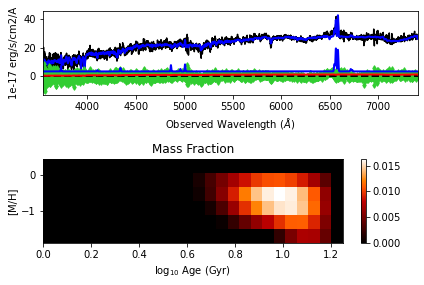

In [5]:
#!/usr/bin/env python
##############################################################################
#
# This PPXF_POPULATION_GAS_EXAMPLE_SDSS routine shows how to study stellar
# population with the procedure PPXF, which implements the Penalized Pixel-Fitting
# (pPXF) method by Cappellari M., & Emsellem E., 2004, PASP, 116, 138.
#
# This example shows how to include gas emission lines as templates
# instead of masking them using the GOODPIXELS keyword.
#
# MODIFICATION HISTORY:
#   V1.0.0: Adapted from PPXF_KINEMATICS_EXAMPLE.
#       Michele Cappellari, Oxford, 12 October 2011
#   V1.1.0: Made a separate routine for the construction of the templates
#       spectral library. MC, Vicenza, 11 October 2012
#   V1.1.1: Includes regul_error definition. MC, Oxford, 15 November 2012
#   V2.0.0: Translated from IDL into Python. MC, Oxford, 6 December 2013
#   V2.0.1: Fit SDSS rather than SAURON spectrum. MC, Oxford, 11 December 2013
#   V2.1.0: Includes gas emission as templates instead of masking the spectrum.
#       MC, Oxford, 7 January 2014
#   V2.1.1: Support both Python 2.6/2.7 and Python 3.x. MC, Oxford, 25 May 2014
#   V2.1.2: Illustrates how to print and plot emission lines. MC, Oxford, 5 August 2014
#   V2.1.3: Only includes emission lines falling within the fitted wavelenth range.
#       MC, Oxford, 3 September 2014
#   V2.1.4: Explicitly sort template files as glob() output may not be sorted.
#       Thanks to Marina Trevisan for reporting problems under Linux.
#       MC, Sydney, 4 February 2015
#   V2.1.5: Included origin='upper' in imshow(). Thanks to Richard McDermid
#       for reporting a different default value with older Matplotlib versions.
#       MC, Oxford, 17 February 2015
#   V2.1.6 -- Use color= instead of c= to avoid new Matplotlib bug.
#       MC, Oxford, 25 February 2015
#   V2.1.7: Support both Pyfits and Astropy to read FITS files.
#       MC, Oxford, 22 October 2015
#
##############################################################################

from __future__ import print_function

try:
    import pyfits
except:
    from astropy.io import fits as pyfits
from scipy import ndimage
import numpy as np
import glob
import matplotlib.pyplot as plt
from time import clock

from ppxf import ppxf
#import ppxf
#from ppxf import *
import ppxf_util as util

def setup_spectral_library(velscale, FWHM_gal):

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis et al. (2010, MNRAS, 404, 1639) http://miles.iac.es/.
    #
    # For this example I downloaded from the above website a set of
    # model spectra with default linear sampling of 0.9A/pix and default
    # spectral resolution of FWHM=2.51A. I selected a Salpeter IMF
    # (slope 1.30) and a range of population parameters:
    #
    #     [M/H] = [-1.71, -1.31, -0.71, -0.40, 0.00, 0.22]
    #     Age = range(1.0, 17.7828, 26, /LOG)
    #
    # This leads to a set of 156 model spectra with the file names like
    #
    #     Mun1.30Zm0.40T03.9811.fits
    #
    # IMPORTANT: the selected models form a rectangular grid in [M/H]
    # and Age: for each Age the spectra sample the same set of [M/H].
    #
    # We assume below that the model spectra have been placed in the
    # directory "miles_models" under the current directory.
    #
    file_dir = '/obs/salome/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/ppxf/'
    vazdekis = glob.glob(file_dir+'miles_models/Mun1.30*.fits')
    vazdekis.sort()
    FWHM_tem = 2.51 # Vazdekis+10 spectra have a resolution FWHM of 2.51A.

    # Extract the wavelength range and logarithmically rebin one spectrum
    # to the same velocity scale of the SDSS galaxy spectrum, to determine
    # the size needed for the array which will contain the template spectra.
    #
    hdu = pyfits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lamRange_temp = h2['CRVAL1'] + np.array([0.,h2['CDELT1']*(h2['NAXIS1']-1)])
    sspNew, logLam_temp, velscale = util.log_rebin(lamRange_temp, ssp, velscale=velscale)

    # Create a three dimensional array to store the
    # two dimensional grid of model spectra
    #
    nAges = 26
    nMetal = 6
    templates = np.empty((sspNew.size,nAges,nMetal))

    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
    sigma = FWHM_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

    # Here we make sure the spectra are sorted in both [M/H]
    # and Age along the two axes of the rectangular grid of templates.
    # A simple alphabetical ordering of Vazdekis's naming convention
    # does not sort the files by [M/H], so we do it explicitly below
    #
    metal = ['m1.71', 'm1.31', 'm0.71', 'm0.40', 'p0.22']# 'p0.00'] IS MISSING (PB INDEX)
    for k, mh in enumerate(metal):
        files = [s for s in vazdekis if mh in s]
        for j, filename in enumerate(files):
            hdu = pyfits.open(filename)
            ssp = hdu[0].data
            ssp = ndimage.gaussian_filter1d(ssp,sigma)
            sspNew, logLam2, velscale = util.log_rebin(lamRange_temp, ssp, velscale=velscale)
            templates[:,j,k] = sspNew # Templates are *not* normalized here

    return templates, lamRange_temp, logLam_temp

#------------------------------------------------------------------------------

def ppxf_population_gas_example_sdss():

    # Read SDSS DR8 galaxy spectrum taken from here http://www.sdss3.org/dr8/
    # The spectrum is *already* log rebinned by the SDSS DR8
    # pipeline and log_rebin should not be used in this case.
    #
    
    
    
    
    z = 0.1090429                    # Initial estimate of the galaxy redshift
    #Find a spectrum using astroquery
    pos = coords.SkyCoord('146.75035d 25.6793d', frame='icrs')
    xid = SDSS.query_region(pos, spectro=True,radius=2*u.arcsec)
    sp = SDSS.get_spectra(matches=xid)
    mask = (10.**sp[0][1].data['loglam']/(1+z) > 3540) & (10.**sp[0][1].data['loglam']/(1+z)< 7409)
    flux =sp[0][1].data['flux'][mask]
    galaxy = flux/np.median(flux)
    wave = 10.**sp[0][1].data['loglam'][mask]/(1+z)
    #FWHM_gal = 2.65  # SAMI has an instrumental resolution FWHM of 2.65A.
    
    
    
    
    #file_dir = '/obs/salome/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/ppxf/'
    #file = file_dir+'spectra/NGC3522_SDSS_DR8.fits'
    #hdu = pyfits.open(file)
    #t = hdu[1].data
    #z = float(hdu[1].header["Z"]) # SDSS redshift estimate
    ## Only use the wavelength range in common between galaxy and stellar library.
    ##
    #mask = (t['wavelength'] > 3540) & (t['wavelength'] < 7409)
    #flux = t['flux'][mask]
    #galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
    #wave = t['wavelength'][mask]

    
    
    
    
    # The noise level is chosen to give Chi^2/DOF=1 without regularization (REGUL=0).
    # A constant error is not a bad approximation in the fitted wavelength
    # range and reduces the noise in the fit.
    noise = galaxy*0 + 0.01528           # Assume constant noise per pixel here

    # The velocity step was already chosen by the SDSS pipeline
    # and we convert it below to km/s
    #
    c = 299792.458 # speed of light in km/s
    velscale = np.log(wave[1]/wave[0])*c
    FWHM_gal = 2.76 # SDSS has an instrumental resolution FWHM of 2.76A.

    #------------------- Setup templates -----------------------

    stars_templates, lamRange_temp, logLam_temp = \
        setup_spectral_library(velscale, FWHM_gal)

    # The stellar templates are reshaped into a 2-dim array with each spectrum
    # as a column, however we save the original array dimensions, which are
    # needed to specify the regularization dimensions
    #
    reg_dim = stars_templates.shape[1:]
    stars_templates = stars_templates.reshape(stars_templates.shape[0], -1)

    # See the pPXF documentation for the keyword REGUL,
    # for an explanation of the following two lines
    #
    stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
    regul_err = 0.004 # Desired regularization error

    # Construct a set of Gaussian emission line templates.
    # Estimate the wavelength fitted range in the rest frame.
    #
    lamRange_gal = np.array([np.min(wave), np.max(wave)])
    gas_templates, line_names, line_wave = \
        util.emission_lines(logLam_temp, lamRange_gal, FWHM_gal)

    # Combines the stellar and gaseous templates into a single array
    # during the PPXF fit they will be assigned a different kinematic
    # COMPONENT value
    #
    templates = np.hstack([stars_templates, gas_templates])

    #-----------------------------------------------------------

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below as described
    # in PPXF_KINEMATICS_EXAMPLE_SAURON.
    #
    c = 299792.458
    dv = (np.log(lamRange_temp[0])-np.log(wave[0]))*c # km/s
    vel = 0. #c*z # Initial estimate of the galaxy velocity in km/s

    # Here the actual fit starts. The best fit is plotted on the screen.
    #
    # IMPORTANT: Ideally one would like not to use any polynomial in the fit
    # as the continuum shape contains important information on the population.
    # Unfortunately this is often not feasible, due to small calibration
    # uncertainties in the spectral shape. To avoid affecting the line strength of
    # the spectral features, we exclude additive polynomials (DEGREE=-1) and only use
    # multiplicative ones (MDEGREE=10). This is only recommended for population, not
    # for kinematic extraction, where additive polynomials are always recommended.
    #
    start = [vel, 180.] # (km/s), starting guess for [V,sigma]

    t = clock()

    # Assign component=0 to the stellar templates and
    # component=1 to the gas emission lines templates.
    # One can easily assign different kinematic components to different gas species
    # e.g. component=1 for the Balmer series, component=2 for the [OIII] doublet, ...)
    # Input a negative MOMENTS value to keep fixed the LOSVD of a component.
    #
    nTemps = stars_templates.shape[1]
    nLines = gas_templates.shape[1]
    component = [0]*nTemps + [1]*nLines
    moments = [4, 2] # fit (V,sig,h3,h4) for the stars and (V,sig) for the gas
    start = [start, start] # adopt the same starting value for both gas and stars

    pp = ppxf.ppxf(templates, galaxy, noise, velscale, start,
              plot=True, moments=moments, degree=-1, mdegree=10,
              vsyst=dv, clean=False, regul=1./regul_err,
              reg_dim=reg_dim, component=component)

    print(pp.gas_flux)
    print(pp)
    # Plot fit results for stars and gas

    plt.clf()
    plt.subplot(211)
    plt.plot(wave, pp.galaxy*np.median(flux), 'k')
    plt.plot(wave, pp.bestfit*np.median(flux), 'b', linewidth=2)
    plt.xlabel("Observed Wavelength ($\AA$)")
    #plt.ylabel("Relative Flux")
    plt.ylabel("1e-17 erg/s/cm2/A")

    #plt.ylim([-0.1,2.7])
    plt.xlim([np.min(wave), np.max(wave)])
    plt.plot(wave, (pp.galaxy-pp.bestfit)*np.median(flux), 'd', ms=4, color='LimeGreen', mec='LimeGreen') # fit residuals
    plt.axhline(y=-0, linestyle='--', color='k', linewidth=2)
    stars = pp.matrix[:,:nTemps].dot(pp.weights[:nTemps])
    plt.plot(wave, stars, 'r', linewidth=2) # overplot stellar templates alone
    gas = pp.matrix[:,-nLines:].dot(pp.weights[-nLines:])
    plt.plot(wave, (gas+0.15)*np.median(flux), 'b', linewidth=2) # overplot emission lines alone

    # When the two Delta Chi^2 below are the same, the solution is the smoothest
    # consistent with the observed spectrum.
    #
    print('Desired Delta Chi^2: %.4g' % np.sqrt(2*galaxy.size))
    print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1)*galaxy.size))
    print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    w = np.where(np.array(component) == 1)[0] # Extract weights of gas emissions
    print('++++++++++++++++++++++++++++++')
    print('Gas V=%.4g and sigma=%.2g km/s' % (pp.sol[1][0], pp.sol[1][1]))
    print('Emission lines peak intensity:')
    for name, weight, line in zip(line_names, pp.weights[w], pp.matrix[:,w].T):
        print('%12s: %.3g' % (name, weight*np.max(line)*np.median(flux)))
    print('------------------------------')

    # Plot stellar population mass distribution

    plt.subplot(212)
    weights = pp.weights[:np.prod(reg_dim)].reshape(reg_dim)/pp.weights.sum()
    plt.imshow(np.rot90(weights), interpolation='nearest', 
               cmap='gist_heat', aspect='auto', origin='upper', 
               extent=(np.log10(1.0), np.log10(17.7828), -1.9, 0.45))
    plt.colorbar()
    plt.title("Mass Fraction")
    plt.xlabel("log$_{10}$ Age (Gyr)")
    plt.ylabel("[M/H]")
    plt.tight_layout()
    plt.show()
    return galaxy, pp.bestfit, pp.gas_flux

#------------------------------------------------------------------------------

if __name__ == '__main__':
    gal, ppbest, gas_flux=ppxf_population_gas_example_sdss()

In [6]:
DlamHa=165/3e5*6564.6*(1+0.1090429)
DlamNII=165/3e5*6583*(1+0.1090429)
DlamOIII=165/3e5*5007*(1+0.1090429)
DlamHb=165/3e5*4862.7*(1+0.1090429)
Fa=15.1
Fn=14.6
Fo=5.07
Fb=1
print("Flux Ha = "+str(round(DlamHa*Fa,2))+" erg/s/cm2")
print("Flux NII = "+str(round(DlamNII*Fn,2))+" erg/s/cm2")
print("Flux OIII = "+str(round(DlamOIII*Fo,2))+" erg/s/cm2")
print("Flux Hb < "+str(round(DlamHb*Fb,2))+" erg/s/cm2")
print("")
print("log10(NII/Ha) = "+str(np.log10(round(DlamHa*Fa,2)/round(DlamNII*Fn,2))))
print("log10(OIII/Hb) > "+str(np.log10(round(DlamOIII*Fo,2)/round(DlamHb*Fb,2))))

Flux Ha = 60.46 erg/s/cm2
Flux NII = 58.63 erg/s/cm2
Flux OIII = 15.48 erg/s/cm2
Flux Hb < 2.97 erg/s/cm2

log10(NII/Ha) = 0.013348248657000964
log10(OIII/Hb) > 0.7170145070296614
